# Compare SLAV-seq alignment quality against hs38d1 vs hs1 genomes

Collect the following features for all read1:

1. \# duplicates
2. mapq distribution
3. supplementary alignments
4. secondary alignments
5. \# unmapped


## 1. Collect the features

In [68]:
import glob, tempfile, pysam
import pandas as pd
import seaborn as sns
from pathlib import Path
from collections import defaultdict
from tqdm import tqdm

In [52]:
bams = {"ref": [], "sample": [], "file": []}

In [53]:
for ref in ["hs1", "hs38d1"]:
    for f in glob.glob(f"../../results/{ref}/align/CommonBrain/*.sorted.bam"):
        bams["ref"].append(ref)
        bams["file"].append(f)
        bams["sample"].append(Path(f).name.rstrip("aln.tagged.sorted.bam"))
bams = pd.DataFrame(bams)

In [59]:
bams.loc[[0, 1], :]

,ref,sample,file
0,hs1,plate2_G6_S97,../../results/hs1/align/CommonBrain/plate2_G6_...
1,hs1,plate2_A5_S83,../../results/hs1/align/CommonBrain/plate2_A5_...


In [69]:
%%time

dfs = []

for b in tqdm(bams.itertuples()):

    f = defaultdict(list)

    with pysam.AlignmentFile(b.file) as bam:

        for r in bam.fetch():

            if r.is_read2:
                continue

            if r.is_duplicate:
                f["is_dup"].append(True)
            else:
                f["is_dup"].append(False)

            if r.is_unmapped:
                f["is_unmapped"].append(True)
            else:
                f["is_unmapped"].append(False)

            if r.is_proper_pair:
                f["is_proper_pair"].append(True)
            else:
                f["is_proper_pair"].append(False)

            if r.is_secondary:
                f["is_primary"].append(False)
            elif r.is_supplementary:
                f["is_primary"].append(False)
            else:
                f["is_primary"].append(True)

            f["mapq"].append(r.mapping_quality)

    df = pd.DataFrame(f)
    df["sample"] = b.sample
    df["ref"] = b.ref
    dfs.append(df)

204it [1:15:38, 22.25s/it]

CPU times: user 1h 12min 49s, sys: 2min 7s, total: 1h 14min 56s
Wall time: 1h 15min 38s


In [70]:
df = pd.concat(dfs)

In [92]:
df.head()

,is_dup,is_unmapped,is_proper_pair,is_primary,mapq,sample,ref
0,False,False,True,True,0,plate2_G6_S97,hs1
1,False,False,True,True,0,plate2_G6_S97,hs1
2,False,False,True,True,0,plate2_G6_S97,hs1
3,False,False,True,False,0,plate2_G6_S97,hs1
4,False,False,False,True,0,plate2_G6_S97,hs1


## 2. Visualize differences

In [78]:
%%time

mean_df = df.groupby(["ref", "sample"]).mean("mapq")

<Axes: xlabel='diff', ylabel='Count'>

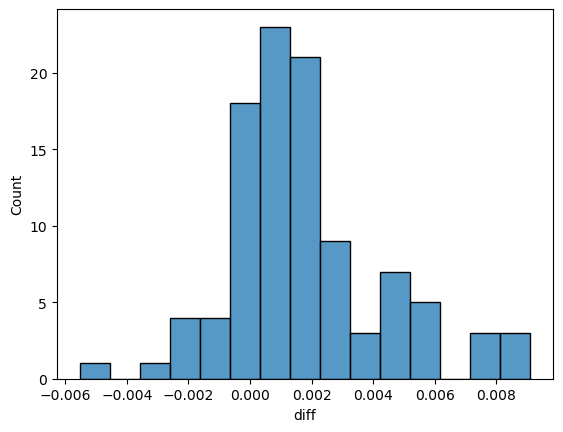

In [104]:
plot_df = mean_df["is_dup"].unstack().transpose()
plot_df["diff"] = plot_df["hs1"] - plot_df["hs38d1"]
sns.histplot(plot_df, x="diff")

<Axes: xlabel='diff', ylabel='Count'>

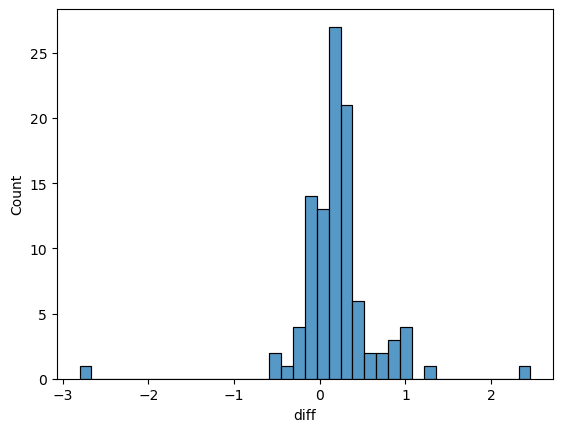

In [103]:
plot_df = mean_df["mapq"].unstack().transpose()
plot_df["diff"] = plot_df["hs1"] - plot_df["hs38d1"]
sns.histplot(plot_df, x="diff")

## 3. Exclude duplicates and re-visualize

In [107]:
%%time

mean_df = df[df["is_dup"] == False].groupby(["ref", "sample"]).mean("mapq")

CPU times: user 1min 14s, sys: 31 s, total: 1min 45s
Wall time: 1min 45s


<Axes: xlabel='diff', ylabel='Count'>

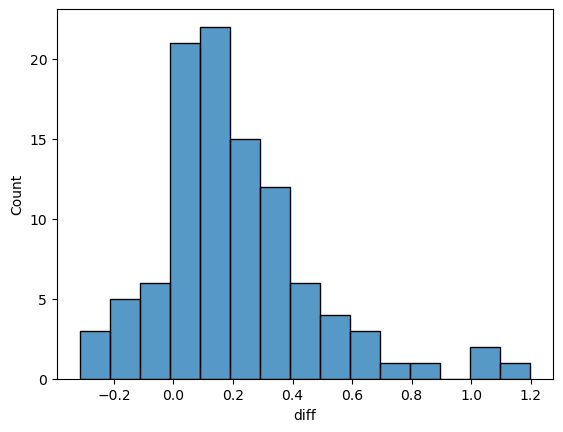

In [108]:
plot_df = mean_df["mapq"].unstack().transpose()
plot_df["diff"] = plot_df["hs1"] - plot_df["hs38d1"]
sns.histplot(plot_df, x="diff")

## Conclusion

Move forward with hs1